## Data download


In [5]:
# !pip install kaggle --user
# !mkdir kaggle
# !echo test > touch kaggle/kaggle.json

# import os

# api_token = {"username":"jasperchan5","key":"20254bbf913a3f9c9b88b66458f747a8"}

# import json

# with open('kaggle/kaggle.json', 'w') as file:
#     json.dump(api_token, file)

# !echo test > chmod 600 kaggle/kaggle.json
# if os.path.exists("finding-lungs-in-ct-data.zip") == False:
#   !echo test > kaggle datasets download -d kmader/finding-lungs-in-ct-data
#   !echo test > unzip finding-lungs-in-ct-data.zip
# else:
#   print("File already existed")

## Data preprocessing functions by Reza



In [6]:
from __future__ import division
import numpy as np
from scipy.ndimage.morphology import binary_erosion, binary_fill_holes

# Functions
def hu_to_grayscale(volume):
    volume = np.clip(volume, -512, 512)
    mxval  = np.max(volume)
    mnval  = np.min(volume)
    im_volume = (volume - mnval)/max(mxval - mnval, 1e-3)
    im_volume = im_volume
    return im_volume *255

def get_mask_alung(vol):
    vol_im = np.where(vol>0, 1, 0)
    shp    = vol.shape
    around_lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
    for idx in range(shp[0]):
            around_lung[idx, :, :] = binary_erosion(vol_im[idx], structure=np.ones((15,15))).astype(vol_im.dtype)
            
    return around_lung

def get_mask(segmentation):
    # initialize output to zeros
    shp    = segmentation.shape
    lung = np.zeros((shp[0], shp[1], shp[2]), dtype=np.float32)
   
    # Get mask for kidney and tumor
    lung[np.equal(segmentation,255)] = 255
    
    return lung
    
def get_FOV(around_lung, lung):
    FOV = np.where((around_lung + lung) >0, 1, 0)
    for idx in range(FOV.shape[0]):
        FOV[idx, :, :] = binary_fill_holes(FOV[idx, :, :], structure=np.ones((5,5))).astype(FOV.dtype)
    return FOV

def return_axials(vol, seg):

    # Prepare segmentation and volume
    vol = vol.get_data()
    seg = seg.get_data()
    seg = seg.astype(np.int32)
    
    # Convert to a visual format
    vol_ims = hu_to_grayscale(vol)
    lung    = get_mask(seg)
    around_lung = get_mask_alung(vol_ims)
    FOV = get_FOV(around_lung, lung)
    around_lung = np.where((FOV - lung) >0, 1, 0)

    return vol_ims, lung, around_lung, FOV

C:\Users\oplab\AppData\Local\Temp\ipykernel_18700\3134109317.py:3: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_fill_holes
C:\Users\oplab\AppData\Local\Temp\ipykernel_18700\3134109317.py:3: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion, binary_fill_holes


## Data preparing

In [7]:
from __future__ import division
import nibabel as nib
import numpy as np
# import Reza_functions as RF
# import nibabel as nib
import glob
import os
from tqdm import tqdm

# Define Train data and mask
Data_train   = []
Mask_train   = []
Maska_train  = []
FOV_train    = []

idx_count =1
Tr_add = '3d_images'

Tr_list = glob.glob(Tr_add+'/*.gz')
print(Tr_list)

for idx in range(len(Tr_list)):
    b = Tr_list[idx]
    a = b[len(Tr_add)+1:len(Tr_add)+4]
    if a=='IMG':
        print(idx_count)
        a = b[len(Tr_add)+5:len(b)]
        add = (Tr_add+'/MASK_' + a) 
        vol = nib.load(Tr_list[idx])
        seg = nib.load(add)
        print(vol.shape, seg.shape)
        # Get the axials images and corresponding masks
        vol_ims, lung, around_lung, FOV = return_axials(vol, seg)        
        segmentation  = seg.get_data()
        # Insert samples to the Train data, which has the segmentation label
        removed_cnt = 0
        for idx in tqdm(range(vol.shape[0])):
           if ~( np.sum(np.sum(np.sum(segmentation[idx, :, :]))) == 0): 
               Data_train.append(vol_ims [idx, :, :])
               Mask_train.append(lung[idx, :, :])
               Maska_train.append(around_lung[idx, :, :])               
               FOV_train.append(FOV[idx, :, :])               
           else:
               removed_cnt += 1
        print(removed_cnt)
        idx_count += 1

print("Loop done")
        
Data_train  = np.array(Data_train)
Mask_train  = np.array(Mask_train)
Maska_train = np.array(Maska_train)
FOV_train   = np.array(FOV_train)
print("Array generation done")

print(Data_train.shape, Mask_train.shape, Maska_train.shape, FOV_train)

# We use 70% of the data for training and 30% for test
alpha = np.int16(np.floor(Data_train.shape[0]* 0.7))
en_d  = Data_train.shape[0]

Train_img      = Data_train[0:alpha,:,:]
Test_img       = Data_train[alpha:en_d,:,:]

Train_mask     = Mask_train[0:alpha,:,:]
Test_mask      = Mask_train[alpha:en_d,:,:]

Train_maska     = Maska_train[0:alpha,:,:]
Test_maska      = Maska_train[alpha:en_d,:,:]

FOV_tr     = FOV_train[0:alpha,:,:]
FOV_te      = FOV_train[alpha:en_d,:,:]

folder = './processed_data/'
if not os.path.exists(folder):
    os.makedirs(folder)

print("AAAAAA")
    
np.save(folder+'data_train' , Train_img)
print("AAAAAA")
np.save(folder+'data_test'  , Test_img)
print("AAAAAA")
np.save(folder+'mask_train' , Train_mask)
print("AAAAAA")
np.save(folder+'mask_test'  , Test_mask)
print("AAAAAA")

np.save(folder+'Train_maska' , Train_maska)
print("AAAAAA")
np.save(folder+'Test_maska'  , Test_maska)
print("AAAAAA")
np.save(folder+'FOV_tr'      , FOV_tr)
print("AAAAAA")
np.save(folder+'FOV_te'      , FOV_te)

print("Data preparation done")

## ResNet34 - BCDUNet

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

class ConvLSTMCell(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, activation, frame_size):
        super(ConvLSTMCell, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # self.device = torch.device('cpu')

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "relu":
            self.activation = torch.relu

        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels,
            out_channels=4 * out_channels,
            kernel_size=kernel_size,
            padding=padding)

        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

        # Initialize weights using Xavier initialization
        nn.init.xavier_uniform_(self.W_ci)
        nn.init.xavier_uniform_(self.W_co)
        nn.init.xavier_uniform_(self.W_cf)

    def forward(self, X, H_prev, C_prev):
        # print(X.shape, H_prev.shape)
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev)
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev)

        # Current Cell output
        C = forget_gate * C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C)

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C


class ConvLSTM(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, activation, frame_size, return_sequence=False):
        super(ConvLSTM, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # self.device = torch.device('cpu')
        self.out_channels = out_channels
        self.return_sequence = return_sequence

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, kernel_size, padding, activation, frame_size)

    def forward(self, X):
        # X is a frame sequence (batch_size, seq_len, num_channels, height, width)

        # Get the dimensions
        batch_size, seq_len, channels, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, seq_len, self.out_channels, height, width, device=self.device)

        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, height, width, device=self.device)

        # Initialize Cell Input
        C = torch.zeros(batch_size, self.out_channels, height, width, device=self.device)

        # Unroll over time steps
        for time_step in range(seq_len):
            H, C = self.convLSTMcell(X[:, time_step, ...], H, C)
            # H, C = self.convLSTMcell(X, H, C)
            output[:, time_step, ...] = H

        if not self.return_sequence:
            output = torch.squeeze(output[:, -1, ...], dim=1)

        return output

class ConvBLSTM(nn.Module):
    def __init__(self, in_channels, out_channels,
                 kernel_size, padding, activation, frame_size, return_sequence=False):
        super(ConvBLSTM, self).__init__()
        self.return_sequence = return_sequence
        self.forward_cell = ConvLSTM(in_channels, out_channels//2, 
                                     kernel_size, padding, activation, frame_size, return_sequence=True)
        self.backward_cell = ConvLSTM(in_channels, out_channels//2, 
                                     kernel_size, padding, activation, frame_size, return_sequence=True)

    def forward(self, x):
        y_out_forward = self.forward_cell(x)
        reversed_idx = list(reversed(range(x.shape[1])))
        y_out_reverse = self.backward_cell(x[:, reversed_idx, ...])[:, reversed_idx, ...]
        output = torch.cat((y_out_forward, y_out_reverse), dim=2)
        if not self.return_sequence:
            output = torch.squeeze(output[:, -1, ...], dim=1)
        return output


class BCDUNet(nn.Module):
    def __init__(self, input_dim=3, output_dim=3, num_filter=64, frame_size=(256, 256), bidirectional=False, norm='instance'):
        super(BCDUNet, self).__init__()
        self.num_filter = num_filter
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.frame_size = np.array(frame_size)

        if norm == 'instance':
            norm_layer = nn.InstanceNorm2d
        else:
            norm_layer = nn.BatchNorm2d

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
                norm_layer(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                norm_layer(out_channels),
                nn.ReLU(inplace=True)
            )
        
        # Encoder
        resnet34 = models.resnet34(pretrained=True)
        filters = [64, 128, 256, 512]


        self.res_input = resnet34.conv1
        self.res_bn1 = nn.BatchNorm2d(64)
        self.res_bn2 = nn.BatchNorm2d(128)
        self.res_bn3 = nn.BatchNorm2d(256)
        self.res_bn4 = nn.BatchNorm2d(512)
        self.res_relu = nn.ReLU(inplace=False)
        self.res_maxpool = resnet34.maxpool
        self.encoder1 = resnet34.layer2
        self.encoder2 = resnet34.layer3
        self.encoder3 = resnet34.layer4

        self.bridge = nn.Sequential(
            nn.Conv2d(filters[3], filters[3]*2, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(filters[3]*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )

        self.upconv3 = nn.ConvTranspose2d(num_filter * 8, num_filter * 4, kernel_size=2, stride=2)
        self.upconv2 = nn.ConvTranspose2d(num_filter * 4, num_filter * 2, kernel_size=2, stride=2)
        self.upconv1 = nn.ConvTranspose2d(num_filter * 2, num_filter, kernel_size=2, stride=2)
        self.upconv0 = nn.ConvTranspose2d(num_filter, output_dim, kernel_size=2, stride=2)

        self.conv3m = conv_block(num_filter * 8, num_filter * 4)
        self.conv2m = conv_block(num_filter * 4, num_filter * 2)
        self.conv1m = conv_block(num_filter * 2, num_filter)

        self.conv0 = nn.Conv2d(output_dim, output_dim, kernel_size=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        if bidirectional:
            self.clstm1 = ConvBLSTM(num_filter*4, num_filter*2, (3, 3), (1,1), 'tanh', list(self.frame_size//4))
            self.clstm2 = ConvBLSTM(num_filter*2, num_filter, (3, 3), (1,1), 'tanh', list(self.frame_size//2))
            self.clstm3 = ConvBLSTM(num_filter, num_filter//2, (3, 3), (1,1), 'tanh', list(self.frame_size))
        else:
            self.clstm1 = ConvLSTM(num_filter*4, num_filter*2, (3, 3), (1,1), 'tanh', list(self.frame_size//4))
            self.clstm2 = ConvLSTM(num_filter*2, num_filter, (3, 3), (1,1), 'tanh', list(self.frame_size//2))
            self.clstm3 = ConvLSTM(num_filter, num_filter//2, (3, 3), (1,1), 'tanh', list(self.frame_size))

    def forward(self, x):
        N = self.frame_size

        ## Encoder 

        conv1 = self.res_input(x)
        conv1 = self.res_relu(conv1)
        conv1 = self.res_bn1(conv1)
        conv2 = self.encoder1(conv1)
        conv2 = self.res_relu(conv2)
        conv2 = self.res_bn2(conv2)
        conv3 = self.encoder2(conv2)
        conv3 = self.res_bn3(conv3)
        conv4 = self.encoder3(conv3)
        conv4 = self.res_bn4(conv4)

        ## Decoder
        upconv3 = self.upconv3(conv4)
        upconv32 = upconv3.unsqueeze(0).transpose(0, 1)
        upconv32 = torch.cat([upconv32] * 2, dim=1)
        concat3 = self.clstm1(upconv32)
        concat3 = torch.cat((concat3, concat3), 1)
        concat3 = torch.cat((conv3, concat3), 1)
        conv3m = self.conv3m(concat3)
        conv3m = self.relu(conv3m)

        upconv2 = self.upconv2(conv3m)
        upconv22 = upconv2.unsqueeze(0).transpose(0, 1)
        upconv22 = torch.cat([upconv22] * 2, dim=1)
        concat2 = self.clstm2(upconv22)
        concat2 = torch.cat((concat2, concat2), 1)
        concat2 = torch.cat((conv2, concat2), 1)
        conv2m = self.conv2m(concat2)
        conv2m = self.relu(conv2m)

        upconv1 = self.upconv1(conv2m)
        upconv12 = upconv1.unsqueeze(0).transpose(0, 1)
        upconv22 = torch.cat([upconv22] * 2, dim=1)
        concat1 = self.clstm3(upconv12)
        concat1 = torch.cat((concat1, concat1), 1)
        concat1 = torch.cat((conv1, concat1), 1)
        conv1m = self.conv1m(concat1)
        conv1m = self.relu(conv1m)

        upconv0 = self.upconv0(conv1m)
        conv0 = self.conv0(upconv0)

        return conv0




## Training


In [10]:
# -*- coding: utf-8 -*-
# The following code is referenced from Reza Azad's github repository
"""
Created on Sat Jun  8 18:15:43 2019

@author: Reza Azad
"""
from __future__ import division
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# import models as M
import numpy as np
from keras.callbacks import ModelCheckpoint, TensorBoard,ReduceLROnPlateau
from keras import callbacks
import pickle

from torch.utils.data import Dataset
   
####################################  Load Data #####################################
folder = './processed_data/'
tr_data    = np.load(folder+'data_train.npy')
tr_mask    = np.load(folder+'Train_maska.npy')
tr_data    = np.expand_dims(tr_data, axis=3)
tr_mask    = np.expand_dims(tr_mask, axis=3)


plt.imshow(tr_mask[0], cmap='gray')
plt.show()
print('Dataset loaded')

tr_data   = tr_data /255.
print(tr_data.shape, tr_mask.shape)

print('dataset Normalized')

In [12]:
from torch.utils.data import Dataset
np.random.seed(42)

def train_valid_split(data_set, valid_ratio, seed=42):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

class Lung_Dataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)


In [13]:
import random as rd
rd.seed(42)
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# import models as M
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from scipy.ndimage.morphology import binary_erosion
# import tensorflow as tf
   
####################################  Load Data #####################################
folder = './processed_data/'
tr_data    = np.load(folder+'data_train.npy')
# tr_mask    = np.load(folder+'mask_train.npy')
tr_mask    = np.load(folder+'Train_maska.npy')


tr_data    = np.expand_dims(tr_data, axis=3)
tr_mask    = np.expand_dims(tr_mask, axis=3)



print('Dataset loaded')

tr_data   = tr_data /255.
print(tr_data.shape, tr_mask.shape)

print('dataset Normalized')


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

# Hyperparameters
input_dim = 3
output_dim = 3
num_filter = 64
frame_size = (256, 256)
bidirectional = True
norm = 'instance'
batch_size = 2
epochs = 2
learning_rate = 0.0001
vis_cmap = 'gray' if output_dim == 1 else 'rgb'

# torch.cuda.empty_cache()

# Load the dataset
transform = transforms.Compose([
    transforms.Resize(frame_size),
    transforms.ToTensor()
])


# train_data = datasets.VOCSegmentation('./data', year='2012', image_set='train', transform=transform, target_transform=transform)
tr_data = torch.tensor(tr_data).transpose(1, 3)
tr_data = torch.cat([tr_data] * 3, dim=1).numpy()
tr_mask = torch.tensor(tr_mask).transpose(1, 3)
tr_mask = torch.cat([tr_mask] * 3, dim=1).numpy()
print(tr_data.shape)
print(tr_mask.shape)

tr_data, val_data = train_valid_split(tr_data, 0.2)
tr_mask, val_mask = train_valid_split(tr_mask, 0.2)
tr_dataset = Lung_Dataset(tr_data, tr_mask)
val_dataset = Lung_Dataset(val_data, val_mask)
train_loader = DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Tr data:", tr_data.shape, "Val data:", val_data.shape) 
print("Tr mask:", tr_mask.shape, "Val mask:", val_mask.shape) 


# Initialize the model
model = BCDUNet(input_dim, output_dim, num_filter, frame_size, bidirectional, norm).to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def visualize_samples(inputs, generated_outputs, ground_truth, filename):
    num_samples = inputs.size(0)
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, 10))
    fig.tight_layout()

    for i in range(num_samples):
        axes[i, 0].imshow(inputs[i].permute(1, 2, 0))
        axes[i, 0].set_title('Input')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(generated_outputs[i].squeeze(), cmap=vis_cmap)
        axes[i, 1].set_title('Generated Output')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(ground_truth[i].permute(1, 2, 0), cmap=vis_cmap)
        axes[i, 2].set_title('Ground Truth')
        axes[i, 2].axis('off')

    plt.savefig(filename)

def evaluation(y_true, y_scores):
    #Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    precision = np.fliplr([precision])[0] 
    recall = np.fliplr([recall])[0]
    AUC_prec_rec = np.trapz(precision,recall)
    print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
    prec_rec_curve = plt.figure()
    plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
    plt.title('Precision - Recall curve')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower right")
    # plt.savefig(output_folder+"Precision_recall.png")

    #Confusion matrix
    threshold_confusion = 0.5
    print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
    y_pred = np.empty((y_scores.shape[0]))
    for i in range(y_scores.shape[0]):
        if y_scores[i]>=threshold_confusion:
            y_pred[i]=1
        else:
            y_pred[i]=0
    confusion = confusion_matrix(y_true, y_pred)
    print (confusion)
    accuracy = 0
    if float(np.sum(confusion))!=0:
        accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
    print ("Global Accuracy: " +str(accuracy))
    specificity = 0
    if float(confusion[0,0]+confusion[0,1])!=0:
        specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
    print ("Specificity: " +str(specificity))
    sensitivity = 0
    if float(confusion[1,1]+confusion[1,0])!=0:
        sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
    print ("Sensitivity: " +str(sensitivity))
    precision = 0
    if float(confusion[1,1]+confusion[0,1])!=0:
        precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
    print ("Precision: " +str(precision))

    #Jaccard similarity index
    jaccard_index = jaccard_score(y_true, y_pred)
    print ("\nJaccard similarity score: " +str(jaccard_index))

    #F1 score
    F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
    print ("\nF1 score (F-measure): " +str(F1_score))

# Training loop
import math
best_loss = math.inf
not_improve = 0

for epoch in range(epochs):
    model.train()
    batch_idx = 0
    for data, targets in train_loader:
        # Move data and targets to the device
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)
        
        scores = torch.tensor(scores).transpose(1, 3).cpu()
        scores = scores[:,:,:,0].numpy()
        targets = torch.tensor(targets).transpose(1, 3).cpu()
        targets = targets[:,:,:,0].numpy()
        # print(scores.shape, targets.shape)
        
        
        scores = np.where(scores > 0.5, 1, 0)
        targets = np.where(targets > 0.5, 1, 0)
        scores = scores.reshape(scores.shape[0]*scores.shape[1]*scores.shape[2], 1)
        targets = targets.reshape(targets.shape[0]*targets.shape[1]*targets.shape[2], 1)
        evaluation(scores, targets)


        # Backward pass
        optimizer.zero_grad()
        # loss = loss.requires_grad_(True)
        loss.backward()

        # Update weights
        optimizer.step()

        # Print progress
        if batch_idx % int(32/batch_size) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item()}")
        batch_idx += 1

    with torch.no_grad():
        model.eval()
        total_loss = 0
        
        tp_list, fp_list, fn_list = [], [], []
        f1_list = []
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            loss = criterion(scores, targets)
            total_loss += loss.item()
            # print(scores.shape, targets.shape)
            scores = torch.tensor(scores).transpose(1, 3).cpu()
            scores = scores[:,:,:,0].numpy()
            targets = torch.tensor(targets).transpose(1, 3).cpu()
            targets = targets[:,:,:,0].numpy()
            # print(scores.shape, targets.shape)
            
            
            scores = np.where(scores > 0.5, 1, 0)
            targets = np.where(targets > 0.5, 1, 0)
            scores = scores.reshape(scores.shape[0]*scores.shape[1]*scores.shape[2], 1)
            targets = targets.reshape(targets.shape[0]*targets.shape[1]*targets.shape[2], 1)
            evaluation(scores, targets)
            
        print("Avg f1 score:", np.mean(f1_list))
        avg_loss = total_loss / len(val_loader)
        print(f"Evaluation Loss: {avg_loss}")
        if avg_loss < best_loss:
            not_improve = 0
            best_loss = avg_loss
            torch.save(model.state_dict(), "./model_other.pth") # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
        else:
            not_improve += 1
        if not_improve == 3:
            print("Not improving, finish in advance")
            break


print("Training and evaluation completed.")



C:\Users\oplab\AppData\Local\Temp\ipykernel_18700\3956250850.py:17: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion


Dataset loaded
(714, 512, 512, 1) (714, 512, 512, 1)
dataset Normalized
(714, 3, 512, 512)
(714, 3, 512, 512)
Tr data: (572, 3, 512, 512) Val data: (142, 3, 512, 512)
Tr mask: (572, 3, 512, 512) Val mask: (142, 3, 512, 512)


In [11]:
# torch.cuda.memory_allocated(device=None)

## Performance evaluation

C:\Users\oplab\AppData\Local\Temp\ipykernel_18700\2113086356.py:13: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion


Dataset loaded
(307, 512, 512) (307, 3, 512, 512)
(80478208, 1)

Area under the ROC curve: 0.9921735154465684

Area under Precision-Recall curve: 0.9890783593866015

Confusion matrix:  Custom threshold (for positive) of 0.5
[[64887483   174863]
 [  199872 15215990]]
64887483 174863 199872 15215990
Global Accuracy: 0.995343646319759
Specificity: 0.9973123778844372
Sensitivity: 0.9870346530086997
Precision: 0.9886385114587216

Jaccard similarity score: 0.9759642351462168

F1 score (F-measure): 0.9878359312247346


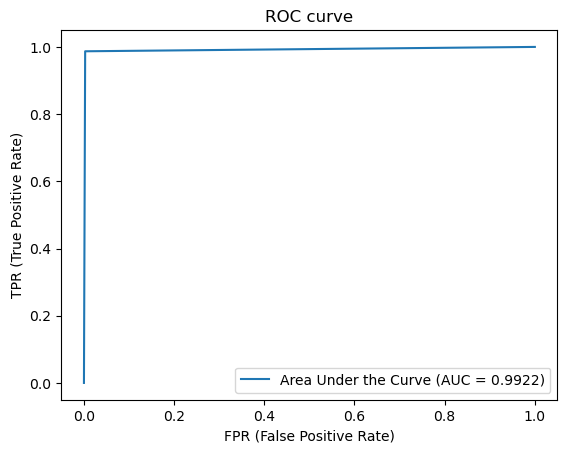

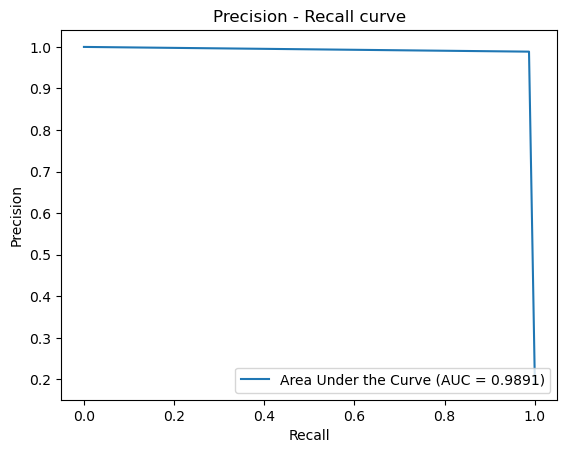

: 

In [16]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# import models as M
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from scipy.ndimage.morphology import binary_erosion
# import tensorflow as tf


####################################  Load Data #####################################
folder    = './processed_data/'
te_data   = np.load(folder+'data_test.npy')
FOV       = np.load(folder+'FOV_te.npy')
te_mask   = np.load(folder+'mask_test.npy')

te_data  = np.expand_dims(te_data, axis=3)

print('Dataset loaded')
#te_data2  = dataset_normalized(te_data)
te_data2 = te_data /255.
te_data2 = torch.tensor(te_data2).transpose(1, 3)
te_data2 = torch.cat([te_data2] * 3, dim=1).numpy()


def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in test_loader:
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

test_dataset = Lung_Dataset(te_data2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluation loop
model = BCDUNet(input_dim, output_dim, num_filter, frame_size, bidirectional, norm).to(device)
model.load_state_dict(torch.load('model.pth', map_location=torch.device("cpu")))
predictions = predict(test_loader, model, device) 



# Post-processing
predictions = np.squeeze(predictions)
predictions = np.where(predictions>0.5, 1, 0)

print(FOV.shape, predictions.shape)
predictions = torch.tensor(predictions).transpose(1, 3)
predictions = predictions[:,:,:,0].numpy()
# Estimated_lung = np.where((FOV - predictions)>0.5, 1, 0)
Estimated_lung = np.where((FOV-predictions)>0.5, 1, 0)

# Performance checking

y_scores = Estimated_lung.reshape(Estimated_lung.shape[0]*Estimated_lung.shape[1]*Estimated_lung.shape[2], 1)
print(y_scores.shape)

y_true = te_mask.reshape(te_mask.shape[0]*te_mask.shape[1]*te_mask.shape[2], 1)

y_scores = np.where(y_scores>0.5, 1, 0)
y_true   = np.where(y_true>0.5, 1, 0)

output_folder = 'output/'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
#Area under the ROC curve
fpr, tpr, thresholds = roc_curve((y_true), y_scores)
AUC_ROC = roc_auc_score(y_true, y_scores)
print ("\nArea under the ROC curve: " +str(AUC_ROC))
roc_curve =plt.figure()
plt.plot(fpr,tpr,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_ROC)
plt.title('ROC curve')
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (True Positive Rate)")
plt.legend(loc="lower right")
plt.savefig(output_folder+"ROC.png")

#Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
precision = np.fliplr([precision])[0] 
recall = np.fliplr([recall])[0]
AUC_prec_rec = np.trapz(precision,recall)
print ("\nArea under Precision-Recall curve: " +str(AUC_prec_rec))
prec_rec_curve = plt.figure()
plt.plot(recall,precision,'-',label='Area Under the Curve (AUC = %0.4f)' % AUC_prec_rec)
plt.title('Precision - Recall curve')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower right")
plt.savefig(output_folder+"Precision_recall.png")

#Confusion matrix
threshold_confusion = 0.5
print ("\nConfusion matrix:  Custom threshold (for positive) of " +str(threshold_confusion))
y_pred = np.empty((y_scores.shape[0]))
for i in range(y_scores.shape[0]):
    if y_scores[i]>=threshold_confusion:
        y_pred[i]=1
    else:
        y_pred[i]=0
confusion = confusion_matrix(y_true, y_pred)
print (confusion)
print(confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1])
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print ("Global Accuracy: " +str(accuracy))
specificity = 0
if float(confusion[0,0]+confusion[0,1])!=0:
    specificity = float(confusion[0,0])/float(confusion[0,0]+confusion[0,1])
print ("Specificity: " +str(specificity))
sensitivity = 0
if float(confusion[1,1]+confusion[1,0])!=0:
    sensitivity = float(confusion[1,1])/float(confusion[1,1]+confusion[1,0])
print ("Sensitivity: " +str(sensitivity))
precision = 0
if float(confusion[1,1]+confusion[0,1])!=0:
    precision = float(confusion[1,1])/float(confusion[1,1]+confusion[0,1])
print ("Precision: " +str(precision))

#Jaccard similarity index
jaccard_index = jaccard_score(y_true, y_pred)
print ("\nJaccard similarity score: " +str(jaccard_index))

#F1 score
F1_score = f1_score(y_true, y_pred, labels=None, average='binary', sample_weight=None)
print ("\nF1 score (F-measure): " +str(F1_score))

#Save the results
file_perf = open(output_folder+'performances.txt', 'w')
file_perf.write("Area under the ROC curve: "+str(AUC_ROC)
                + "\nArea under Precision-Recall curve: " +str(AUC_prec_rec)
                + "\nJaccard similarity score: " +str(jaccard_index)
                + "\nF1 score (F-measure): " +str(F1_score)
                +"\n\nConfusion matrix:"
                +str(confusion)
                +"\nACCURACY: " +str(accuracy)
                +"\nSENSITIVITY: " +str(sensitivity)
                +"\nSPECIFICITY: " +str(specificity)
                +"\nPRECISION: " +str(precision)
                )
file_perf.close()

(307, 512, 512, 1) (307, 512, 512) (307, 512, 512)


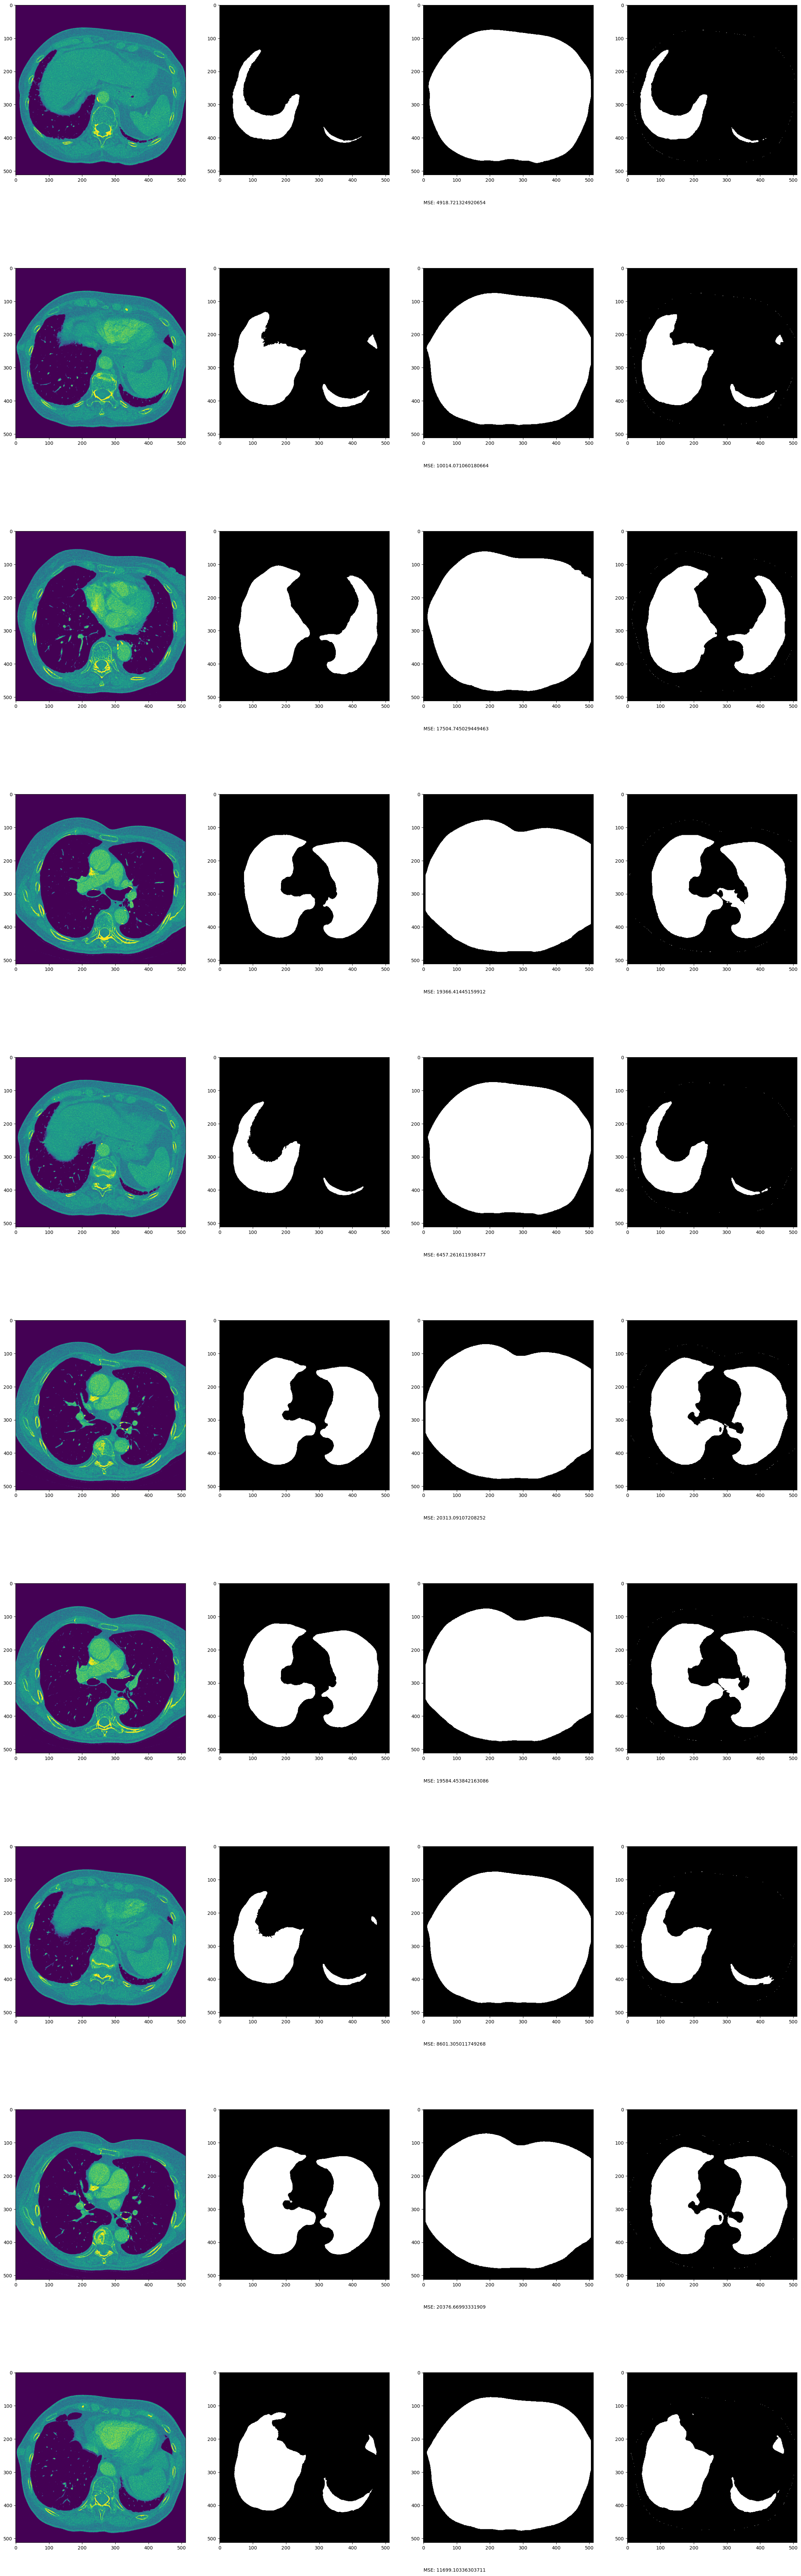

In [30]:
# Sample results
import random
from sklearn.metrics import mean_squared_error
amount = 10
fig,ax = plt.subplots(amount, 4, figsize=[30, 100])
# all_ind = range(len(Estimated_lung))
# all_ind =  [1, 100, 200, 253, 193]  # random samples
all_ind = [1, 14, 51, 114, 5, 100, 111, 10, 99, 19] # random samples
# all_ind = sorted(np.array(all_ind), key=lambda x:mean_squared_error(te_mask[all_ind[x]], Estimated_lung[all_ind[x]]))
# all_ind = [random.choice(all_ind) for _ in range(amount)]
# all_ind = all_ind[:10]
print(te_data.shape, te_mask.shape, Estimated_lung.shape)
for idx in range(amount):
    ax[idx, 0].imshow(np.uint8(np.squeeze(te_data[all_ind[idx]])))
    ax[idx, 1].imshow(np.squeeze(te_mask[all_ind[idx]]), cmap='gray')  
    ax[idx, 2].imshow(np.squeeze(FOV[all_ind[idx]]), cmap='gray')
    ax[idx, 2].text(0, 600, f"MSE: {mean_squared_error(te_mask[all_ind[idx]], Estimated_lung[all_ind[idx]])}")
    # ax[idx, 3].imshow(np.squeeze(np.squeeze(predictions[all_ind[idx]])), cmap='gray')
    ax[idx, 3].imshow(np.squeeze(Estimated_lung[all_ind[idx]]), cmap='gray')
        
plt.savefig('sample_result_mask_around_lung.png')

54 1.3.6.1.4.1.14519.5.2.1.6279.6001.313334055029671473836954456733.mhd
Dataset loaded
2
[[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]] [[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 

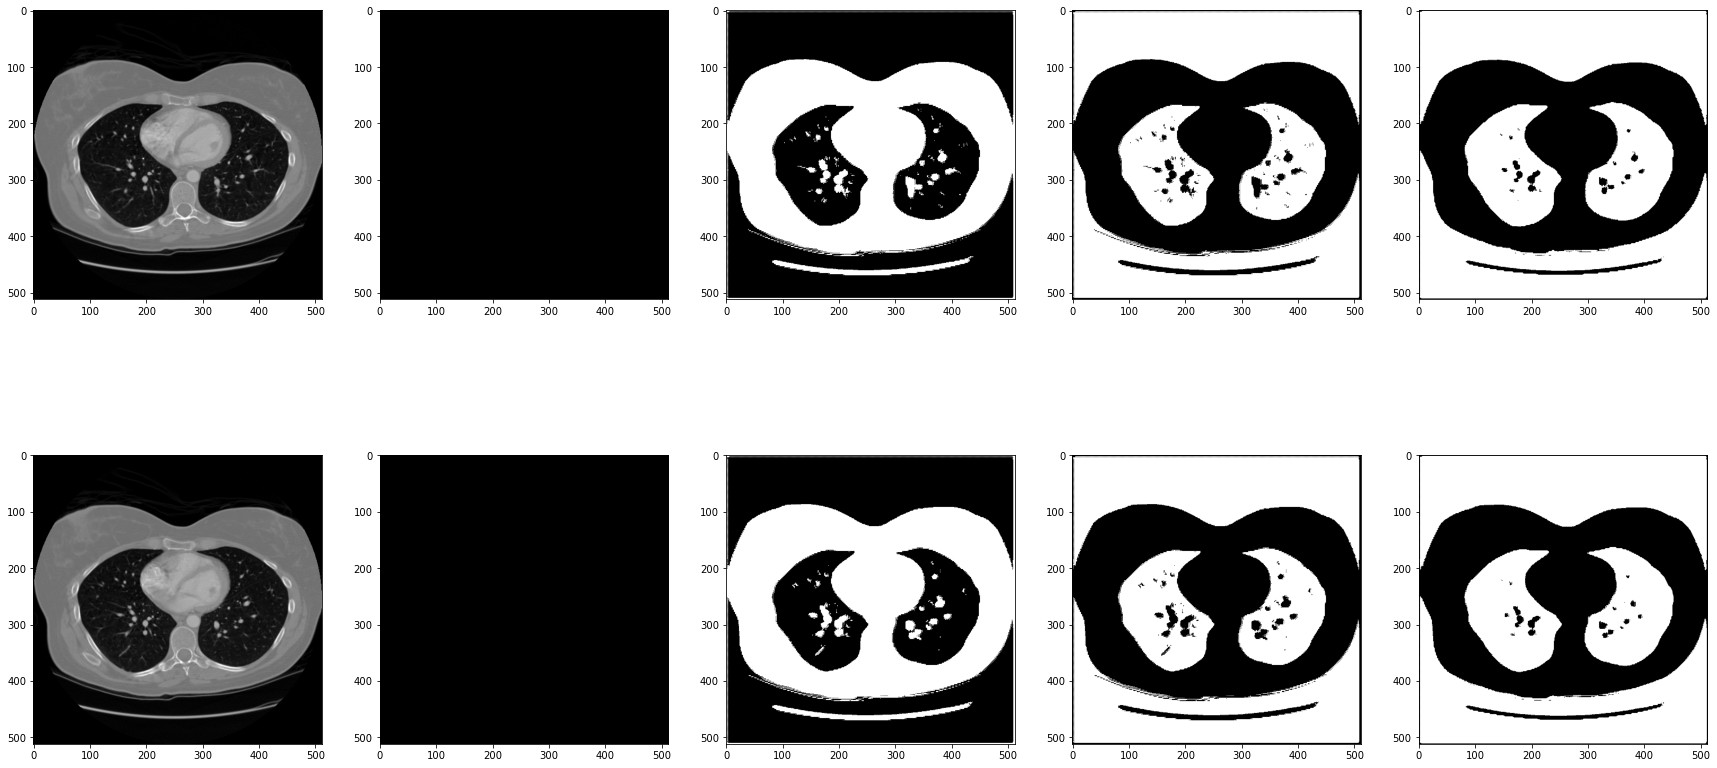

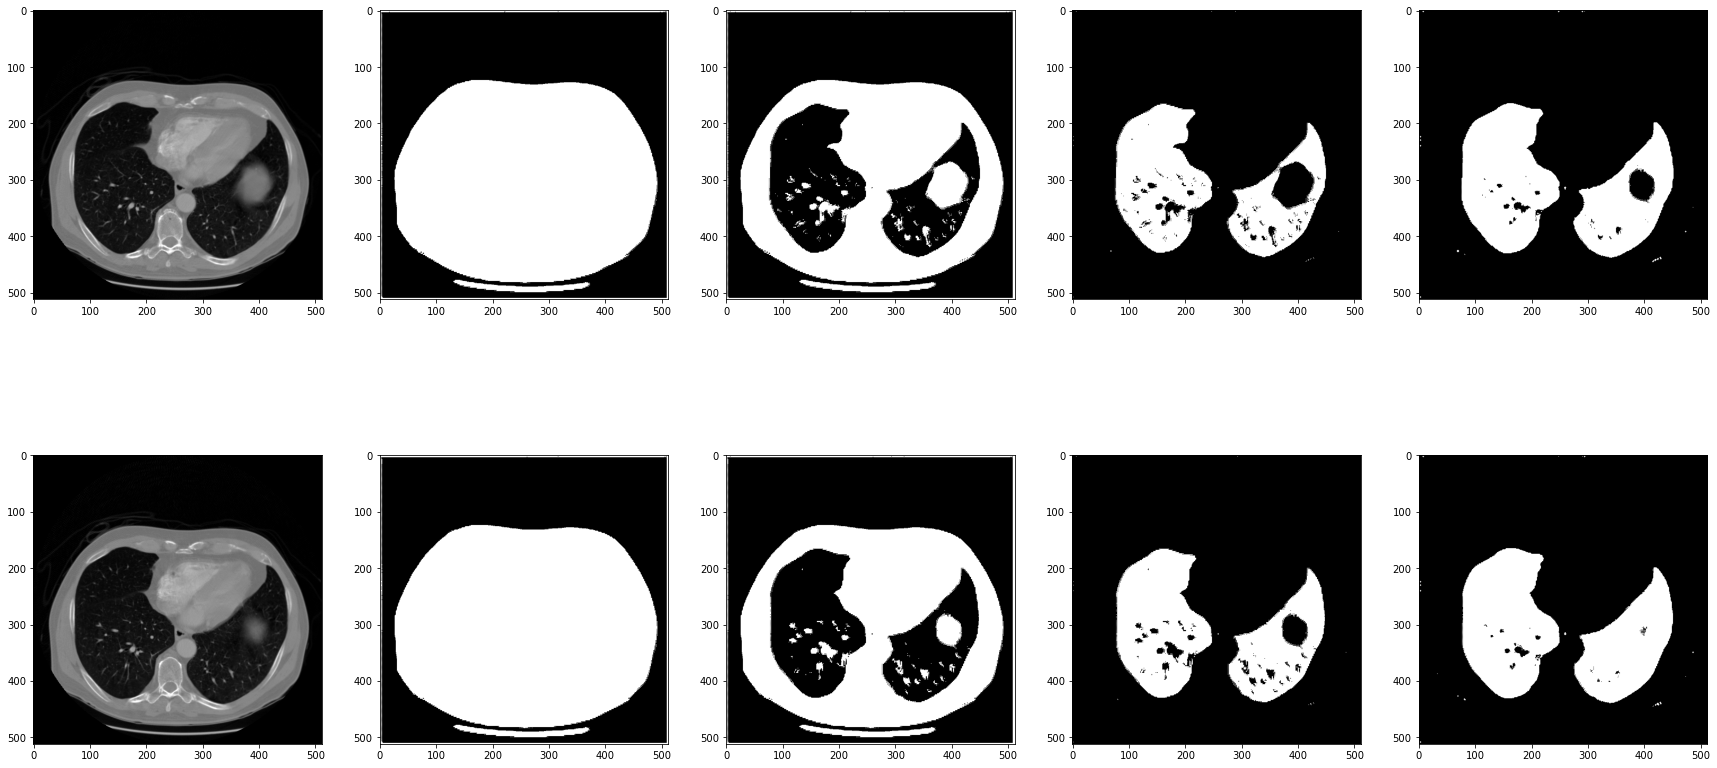

In [22]:
# Load augmentation files

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# import models as M
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from scipy.ndimage.morphology import binary_erosion, binary_fill_holes
# import tensorflow as tf
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from IPython.display import HTML
from base64 import b64encode
import cv2
import SimpleITK as sitk
import nibabel as nib
import skimage, skimage.morphology, skimage.data
import copy

####################################  Load Data #####################################
root = "E:\LUNA\Interpolation\Luna1\image\subset0/"
for e, path in enumerate(os.listdir(root)):
    if path.find("mhd") >= 0 and e > 108 and e < 112:
        print(int(e/2), path)
        te_data = sitk.ReadImage(os.path.join(root, path))
        te_data = sitk.GetArrayFromImage(te_data)
        te_data = te_data[48:52]
        # print(te_data[0:2].shape)
        # continue
        te_data[te_data < -1000] = -1000
        te_data[te_data > 1000] = 1000
        unique, counts = np.unique(te_data, return_counts=True)
        # print(dict(zip(unique, counts)))
        # Define the file path and parameters
        dtype = np.int16  # Data type (change as needed)
        width = 512       # Width of the data
        height = 512      # Height of the data
        channels = 3
        te_data  = np.expand_dims(te_data, axis=3)


        print('Dataset loaded')
        #te_data2  = dataset_normalized(te_data)
        te_data2 = te_data / 255
        te_data2 = torch.tensor(te_data2).transpose(1, 3)
        te_data2 = torch.cat([te_data2] * 3, dim=1).numpy()

        def predict(test_loader, model, device):
            model.eval() # Set your model to evaluation mode.
            preds = []
            for x in test_loader:
                x = x.to(device)                        
                with torch.no_grad():                   
                    pred = model(x)                     
                    preds.append(pred.detach().cpu())   
            preds = torch.cat(preds, dim=0).numpy()  
            return preds

        # Set device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # device = torch.device("cpu")

        # Hyperparameters
        input_dim = 3
        output_dim = 3
        num_filter = 64
        frame_size = (256, 256)
        bidirectional = True
        norm = 'instance'
        batch_size = 2
        epochs = 50
        learning_rate = 0.0001
        vis_cmap = 'gray' if output_dim == 1 else 'rgb'
        test_dataset = Lung_Dataset(te_data2)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        print(len(test_loader))

        # Evaluation loop
        model = BCDUNet(input_dim, output_dim, num_filter, frame_size, bidirectional, norm).to(device)
        model.load_state_dict(torch.load('model.pth', map_location=torch.device("cpu")))
        predictions = predict(test_loader, model, device) 

        # Post-processing
        predictions = np.squeeze(predictions)
        predictions = torch.tensor(predictions).transpose(1, 3)
        predictions = np.where(predictions<0.5, 1, 0)
        Estimated_lung = predictions[:,:,:,0]
        Estimated_lung2 = copy.deepcopy(Estimated_lung)

        Estimated_lung = np.where(Estimated_lung<0.5, 1, 0)
        # Estimated_lung = scipy.ndimage.binary_dilation(Estimated_lung, iterations=5)
        Estimated_lung = scipy.ndimage.binary_fill_holes(Estimated_lung)
        Estimated_lung = np.where(Estimated_lung<0.5, 1, 0)
        
        Estimated_lung2 = np.where(Estimated_lung2<0.5, 1, 0)
        # Estimated_lung2 = scipy.ndimage.binary_dilation(Estimated_lung2, iterations=15)
        # Estimated_lung2 = scipy.ndimage.binary_erosion(Estimated_lung2)
        labels = skimage.morphology.label(Estimated_lung2)
        labelCount = np.bincount(labels.ravel())
        background = np.argmax(labelCount)
        Estimated_lung2[labels != background] = 0
        Estimated_lung2 = np.where(Estimated_lung2<0.5, 1, 0)
        Lung_mask = np.subtract(Estimated_lung2, Estimated_lung)
        # print(Lung_mask)
        Filled_Lung = scipy.ndimage.binary_dilation(Lung_mask)
        Filled_Lung = scipy.ndimage.binary_fill_holes(Filled_Lung)
        labels2 = skimage.morphology.label(Filled_Lung)
        labelCount2 = np.bincount(labels2.ravel())
        background2 = np.argmax(labelCount2)
        Filled_Lung[labels2 != background2] = 1
        # Lung = Lung.astype(int)
        print(Estimated_lung2, Estimated_lung, Lung_mask)

        # Sample results
        import random
        from sklearn.metrics import mean_squared_error
        amount = len(test_loader)
        # print(amount)

        fig,ax = plt.subplots(amount, 5, figsize=[30, 15])
        # plt.bone()
        print(te_data.shape, Estimated_lung.shape)
        for idx in range(amount):
            ax[idx, 0].imshow(np.squeeze(te_data[idx]), cmap='gray')
            ax[idx, 1].imshow(np.squeeze(Estimated_lung2[idx]), cmap='gray')
            ax[idx, 2].imshow(np.squeeze(Estimated_lung[idx]), cmap='gray')
            ax[idx, 3].imshow(np.squeeze(Lung_mask[idx]), cmap='gray')
            ax[idx, 4].imshow(np.squeeze(Filled_Lung[idx]), cmap='gray')
                
        plt.savefig(f'./aug_seg_result/sample_results_{int(e/2)}.png')
